📂 Please upload your CSV (e.g., nba_traditional_RS_2020_2025.csv)


Saving nba_traditional_RS_2020_2025.csv to nba_traditional_RS_2020_2025 (2).csv
✅ Loaded: nba_traditional_RS_2020_2025 (2).csv


/tmp/ipython-input-860267451.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_marked = season_filtered.groupby(by_cols, group_keys=False).apply(mark_high_usage)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved: low_turnover_high_usage_per_season.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

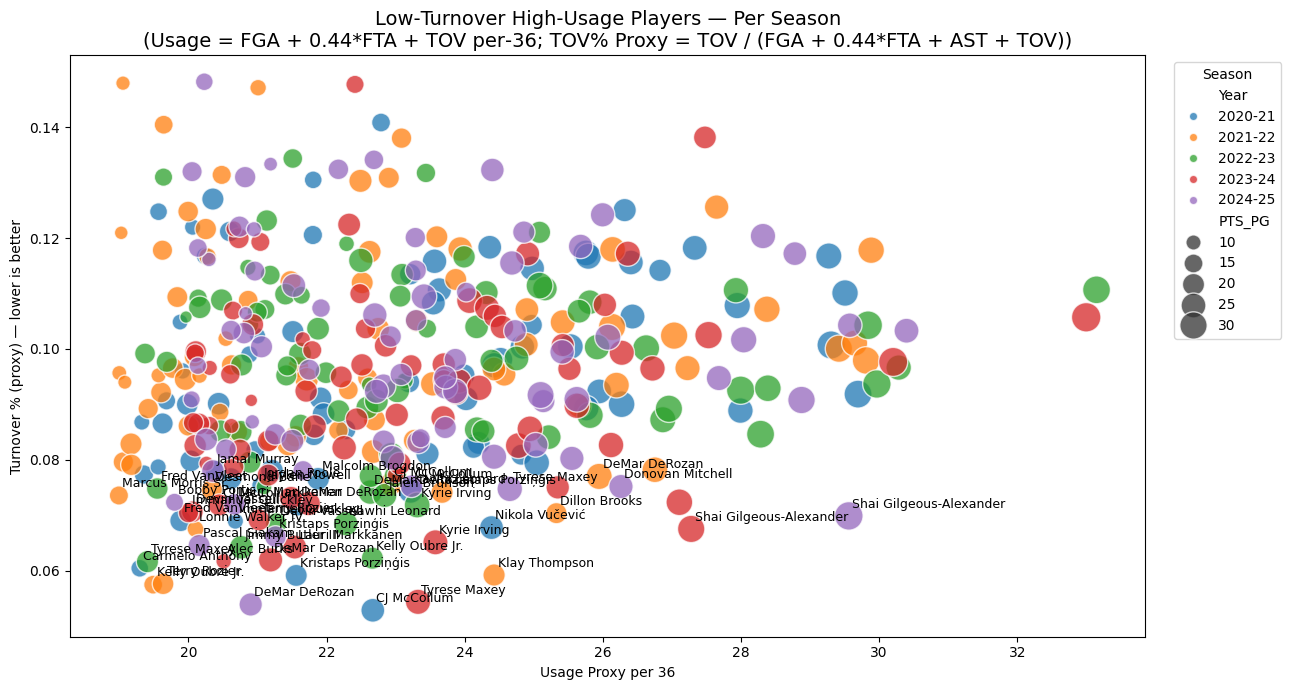

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved: low_turnover_high_usage_span_2020_2025.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

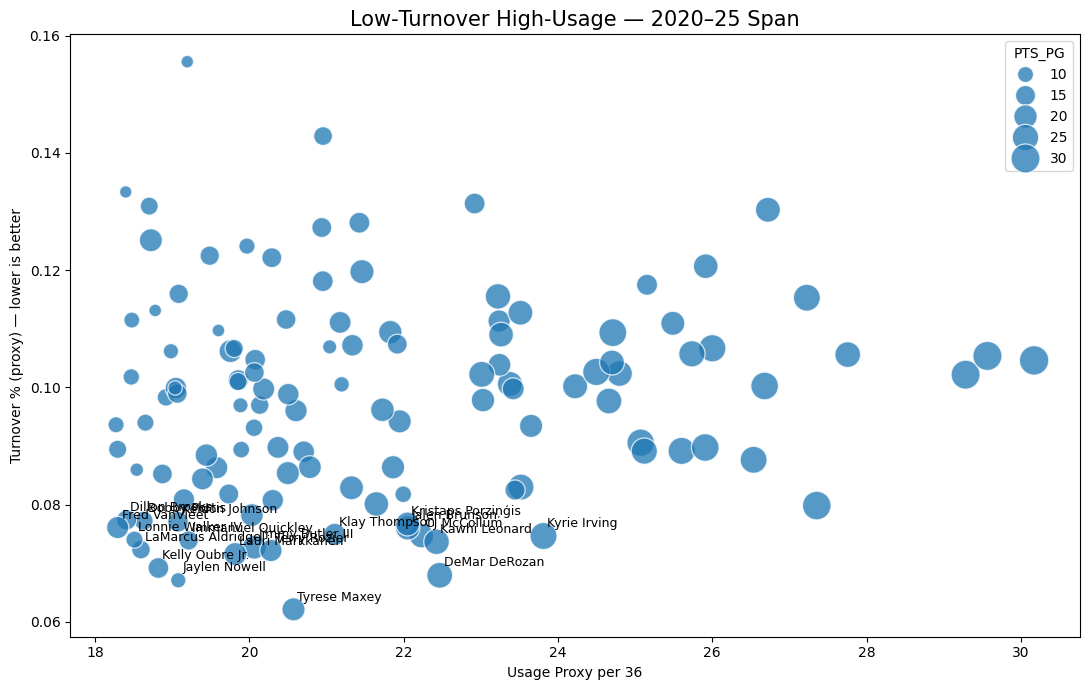

✅ Done! Season and span leaders saved to CSV & PNG.


In [4]:
# 🏀 Low‑Turnover High‑Usage Players (2020–25) — Google Colab Full Notebook
# File: nba_traditional_low_to_high_usage_2020_2025.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# =========================
# 0) SETTINGS (edit here)
# =========================
MIN_GP = 30          # season-level floor
MIN_MIN = 800        # minutes floor to avoid tiny samples
USAGE_TOP_Q = 0.75   # top quartile for "high usage" (0.75 = top 25%)
SEASON_TYPE_FILTER = None  # "Regular Season", "Playoffs", or None for both

# =========================
# 1) Upload & Load
# =========================
print("📂 Please upload your CSV (e.g., nba_traditional_RS_2020_2025.csv)")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"✅ Loaded: {file_name}")

df = pd.read_csv(file_name)

# =========================
# 2) Clean & Prepare
# =========================
# Fix Season_Type encoding
if "Season_Type" in df.columns:
    df["Season_Type"] = df["Season_Type"].astype(str).str.replace("%20", " ", regex=False)

# Ensure numeric
for col in ["GP","MIN","FGA","FTA","TOV","AST","PTS"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep essentials only
keep = ["Year","Season_Type","PLAYER","TEAM","GP","MIN","FGA","FTA","TOV","AST","PTS"]
df = df[[c for c in keep if c in df.columns]].dropna(subset=["Year","PLAYER","GP","MIN","FGA","FTA","TOV","AST"])

# Optional: filter by Season_Type
if SEASON_TYPE_FILTER is not None and "Season_Type" in df.columns:
    df = df[df["Season_Type"] == SEASON_TYPE_FILTER].copy()

# =========================
# 3) Aggregate per player-season (handle trades)
# =========================
group_keys = ["Year","Season_Type","PLAYER"] if "Season_Type" in df.columns else ["Year","PLAYER"]
agg_map = {"GP":"sum","MIN":"sum","FGA":"sum","FTA":"sum","TOV":"sum","AST":"sum","PTS":"sum"}
df_season = df.groupby(group_keys, as_index=False).agg(agg_map)

# =========================
# 4) Derived metrics (per‑36 usage proxy & TOV%)
# =========================
# Usage proxy (possessions used): FGA + 0.44*FTA + TOV
df_season["USG_proxy_total"] = df_season["FGA"] + 0.44*df_season["FTA"] + df_season["TOV"]
# Per‑36 usage proxy
df_season["USG_proxy_P36"] = np.where(
    df_season["MIN"] > 0, (df_season["USG_proxy_total"] / df_season["MIN"]) * 36, np.nan
)
# Turnover Percentage (proxy): TOV / (FGA + 0.44*FTA + AST + TOV)
den = df_season["FGA"] + 0.44*df_season["FTA"] + df_season["AST"] + df_season["TOV"]
df_season["TOV_pct_proxy"] = np.where(den > 0, df_season["TOV"] / den, np.nan)

# Per‑game PTS (for size/label context)
df_season["PTS_PG"] = df_season["PTS"] / df_season["GP"]

# Apply season sample-size filters
season_filtered = df_season[(df_season["GP"] >= MIN_GP) & (df_season["MIN"] >= MIN_MIN)].dropna(
    subset=["USG_proxy_P36","TOV_pct_proxy"]
)

# =========================
# 5) Define high‑usage cutoff (per season)
# =========================
# Mark high‑usage = top quartile of USG_proxy_P36 within each season (and season type, if present)
by_cols = ["Year","Season_Type"] if "Season_Type" in season_filtered.columns else ["Year"]

def mark_high_usage(g):
    cutoff = g["USG_proxy_P36"].quantile(USAGE_TOP_Q)
    g["HighUsage"] = g["USG_proxy_P36"] >= cutoff
    g["UsageCutoff"] = cutoff
    return g

season_marked = season_filtered.groupby(by_cols, group_keys=False).apply(mark_high_usage)

# =========================
# 6) Leaders: low‑turnover among high usage (per season)
# =========================
high_usage = season_marked[season_marked["HighUsage"]].copy()
leaders_per_season = (
    high_usage.sort_values(["Year","TOV_pct_proxy","USG_proxy_P36"], ascending=[True, True, False])
             .groupby(by_cols, group_keys=True)
             .head(10)  # Top 10 per season; change as needed
             .reset_index(drop=True)
)

# Save table
csv_season = "low_turnover_high_usage_per_season.csv"
leaders_per_season.to_csv(csv_season, index=False)
files.download(csv_season)
print(f"✅ Saved: {csv_season}")

# =========================
# 7) Plot — Per season bubble chart with labels
# X = USG proxy per‑36 (higher = more usage)
# Y = TOV% proxy (lower = better)
# Size = PTS per game
# =========================
plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    data=high_usage,
    x="USG_proxy_P36", y="TOV_pct_proxy",
    hue="Year", size="PTS_PG",
    sizes=(80, 450), alpha=0.75
)
# Label only the top-10 per season leaders we saved
for _, r in leaders_per_season.iterrows():
    ax.text(r["USG_proxy_P36"] + 0.05, r["TOV_pct_proxy"] + 0.0015, r["PLAYER"], fontsize=9)

plt.title("Low‑Turnover High‑Usage Players — Per Season\n(Usage = FGA + 0.44*FTA + TOV per‑36; TOV% Proxy = TOV / (FGA + 0.44*FTA + AST + TOV))", fontsize=14)
plt.xlabel("Usage Proxy per 36")
plt.ylabel("Turnover % (proxy) — lower is better")
plt.legend(title="Season", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
png_season = "low_turnover_high_usage_per_season.png"
plt.savefig(png_season, dpi=300)
files.download(png_season)
plt.show()

# =========================
# 8) Span‑wide leaders (2020–25)
# =========================
span = df_season.copy()
span["USG_proxy_P36"] = np.where(
    span["MIN"] > 0, ( (span["FGA"] + 0.44*span["FTA"] + span["TOV"]) / span["MIN"] ) * 36, np.nan
)
den2 = span["FGA"] + 0.44*span["FTA"] + span["AST"] + span["TOV"]
span["TOV_pct_proxy"] = np.where(den2 > 0, span["TOV"] / den2, np.nan)
span["PTS_PG"] = span["PTS"] / span["GP"]

# Aggregate across seasons per player
agg_span = (span.groupby("PLAYER", as_index=False)
                .agg({"GP":"sum","MIN":"sum","FGA":"sum","FTA":"sum","TOV":"sum","AST":"sum","PTS":"sum"}))
agg_span["USG_proxy_P36"] = np.where(
    agg_span["MIN"] > 0, ( (agg_span["FGA"] + 0.44*agg_span["FTA"] + agg_span["TOV"]) / agg_span["MIN"] ) * 36, np.nan
)
den3 = agg_span["FGA"] + 0.44*agg_span["FTA"] + agg_span["AST"] + agg_span["TOV"]
agg_span["TOV_pct_proxy"] = np.where(den3 > 0, agg_span["TOV"] / den3, np.nan)
agg_span["PTS_PG"] = agg_span["PTS"] / agg_span["GP"]

# Span filters
SPAN_MIN_GP = MIN_GP * 2
SPAN_MIN_MIN = MIN_MIN * 2
agg_span_f = agg_span[(agg_span["GP"] >= SPAN_MIN_GP) & (agg_span["MIN"] >= SPAN_MIN_MIN)].dropna(
    subset=["USG_proxy_P36","TOV_pct_proxy"]
)

# Define span high‑usage as top quartile across all players
span_cutoff = agg_span_f["USG_proxy_P36"].quantile(USAGE_TOP_Q)
span_high = agg_span_f[agg_span_f["USG_proxy_P36"] >= span_cutoff].copy()

# Rank by lowest TOV%
span_leaders = span_high.sort_values(["TOV_pct_proxy","USG_proxy_P36"], ascending=[True, False]).head(20)

# Save span table
csv_span = "low_turnover_high_usage_span_2020_2025.csv"
span_leaders.to_csv(csv_span, index=False)
files.download(csv_span)
print(f"✅ Saved: {csv_span}")

# Plot span bubble with labels
plt.figure(figsize=(11, 7))
ax2 = sns.scatterplot(
    data=span_high,
    x="USG_proxy_P36", y="TOV_pct_proxy",
    size="PTS_PG", sizes=(80, 450), alpha=0.75
)
for _, r in span_leaders.iterrows():
    ax2.text(r["USG_proxy_P36"] + 0.05, r["TOV_pct_proxy"] + 0.0015, r["PLAYER"], fontsize=9)

plt.title("Low‑Turnover High‑Usage — 2020–25 Span", fontsize=15)
plt.xlabel("Usage Proxy per 36")
plt.ylabel("Turnover % (proxy) — lower is better")
plt.tight_layout()
png_span = "low_turnover_high_usage_span_2020_2025.png"
plt.savefig(png_span, dpi=300)
files.download(png_span)
plt.show()

print("✅ Done! Season and span leaders saved to CSV & PNG.")